In [82]:
class SaveOutput:
    def __init__(self):
        self.outputs = []

    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)

    def clear(self):
        self.outputs = []


def activations(model, layers, x, device=None):
    """Get all activation vectors over images for a model.
    :param model: A pytorch model
    :type model: currently is Net defined by ourselves
    :param layers: One or more layers that activations are desired
    :type layers: torch.nn.modules.container.Sequential
    :param x: A 4-d tensor containing the test datapoints from which activations are desired.
                The 1st dimension should be the number of test datapoints.
                The next 3 dimensions should match the input of the model
    :type x: torch.Tensor
    :param device: A torch.device, specifying whether to put the input to cpu or gpu.
    :type device: torch.device
    :return (output): A list containing activations of all specified layers.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    save_output = SaveOutput()
    hook_handles = []

    for layer in layers:
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

    with torch.no_grad():
        x = x.to(device)
        y_hat = model(x)

    output = save_output.outputs.copy()
    del save_output, hook_handles, y_hat
    return output


## Load model and data

In [10]:
from pathlib import Path
data_dir = Path("/Users/miaoxinran/Desktop/mappingvis-master/data")
process_dir = data_dir / "processed"
args = {
        "batch_size": 8, # make this bigger if you are not running on binder
    "epochs": 50,
    "device": "cpu", # set to "cuda" if gpu is available
    "out_dir": data_dir / "predictions"
}

In [2]:
from data import download_data

links = {
    "test_data": "https://uwmadison.box.com/shared/static/zs8vtmwbl92j5oq6ekzcfod11ym1w599.gz",
    "model": "https://uwmadison.box.com/shared/static/byb5lpny6rjr15zbx28o8liku8g6nga6.pt"
}

download_data(links["test_data"], process_dir / "test.tar.gz")
download_data(links["model"], data_dir / "model.pt", unzip = False)

In [5]:
import torch
from unet import Unet

state = torch.load("model.pt", map_location=args["device"])
model = Unet(13, 3, 4).to(args["device"])
model.load_state_dict(state)
model = model.eval()

In [4]:
from data import GlacierDataset
from torch.utils.data import DataLoader

paths = {}
for split in ["train", "test"]:
    paths[split] = {}
    for v in ["x", "y"]:
        paths[split][v] = list((process_dir / split).glob(v + "*"))
        paths[split][v].sort()

ds = {
    "train": GlacierDataset(paths["train"]["x"], paths["train"]["y"]),
    "test": GlacierDataset(paths["test"]["x"], paths["test"]["y"])
}

## Representational analysis

In [81]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [16]:
x, y = ds["train"][0]
x.shape,y.shape # (torch.Size([13, 512, 512]), torch.Size([3, 512, 512]))

(torch.Size([13, 512, 512]), torch.Size([3, 512, 512]))

In [18]:
y_hat = model(x.unsqueeze(0))
y_hat.shape #torch.Size([1, 3, 512, 512])

In [170]:
layers = [model.downblocks[0].conv1,
          model.downblocks[0].conv2,
          model.downblocks[1].conv1,
          model.downblocks[1].conv2,
          model.downblocks[2].conv1,
          model.downblocks[2].conv2,
          model.downblocks[3].conv1,
          model.downblocks[3].conv2, # no
         model.upblocks[0].conv.conv1,model.upblocks[0].conv.conv2,
          model.upblocks[1].conv.conv1,model.upblocks[1].conv.conv2,
          model.upblocks[2].conv.conv1,model.upblocks[2].conv.conv2,
          model.upblocks[3].conv.conv1,model.upblocks[3].conv.conv2,
          model.pool,
          model.middle_conv.conv1,
          model.middle_conv.conv2,#yes
         model.seg_layer]

In [171]:
acts = activations(model, layers,x.unsqueeze(0) , device=None)

In [172]:
for i in range(len(acts)):
    print(acts[i].shape)

torch.Size([1, 16, 512, 512])
torch.Size([1, 16, 512, 512])
torch.Size([1, 16, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 64, 64])
torch.Size([1, 128, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([1, 128, 64, 64])
torch.Size([1, 128, 64, 64])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 128, 128])
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 16, 512, 512])
torch.Size([1, 16, 512, 512])
torch.Size([1, 3, 512, 512])


## Plot all activations for every layer

In [193]:
dir = './figures/'

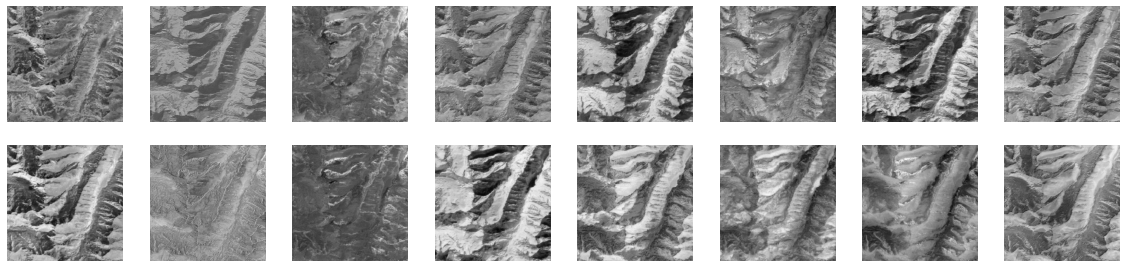

In [233]:
# model.downblocks[0].conv1
rows =8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(16):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[0][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/0.png')

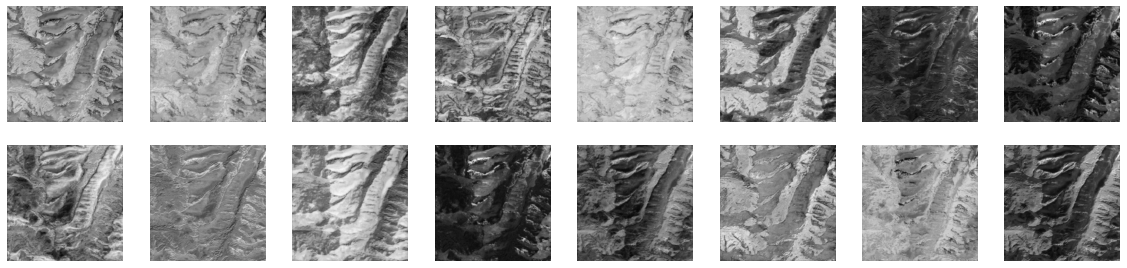

In [234]:
# model.downblocks[0].conv2
rows =8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(16):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[1][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/1.png')

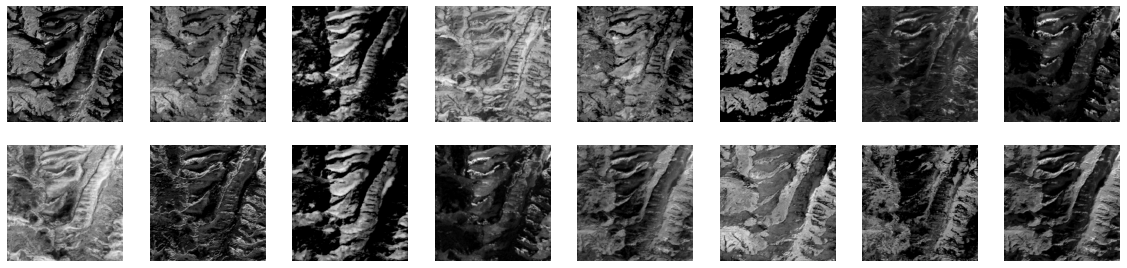

In [235]:
# model.downblocks[1].conv1
rows = 8
columns =8
fig = plt.figure(figsize=(20, 20))
for i in range(16):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[2][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/2.png')

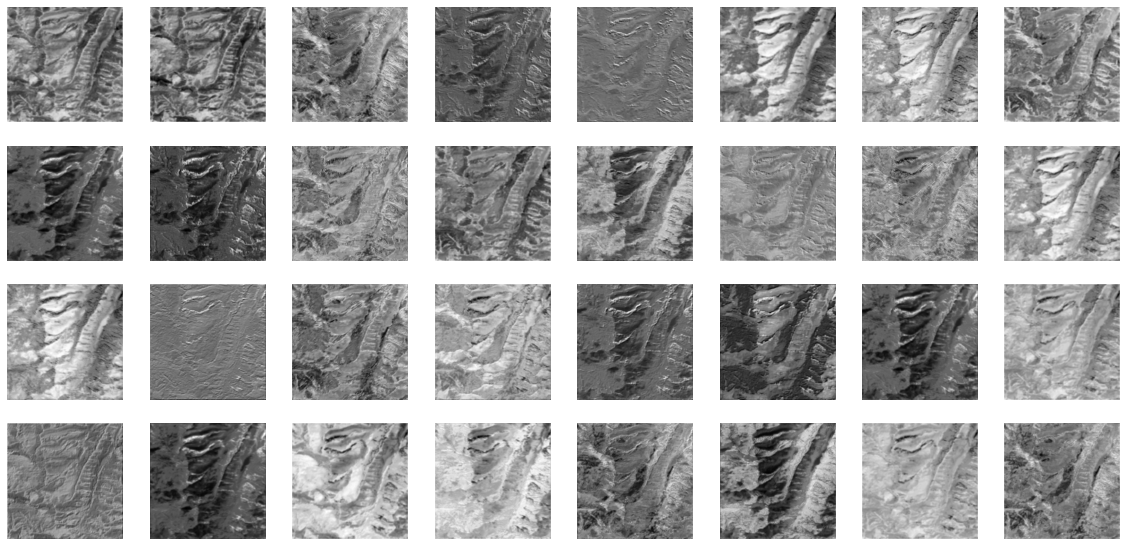

In [215]:
# model.downblocks[1].conv1
rows = 8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(32):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[3][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/3.png')

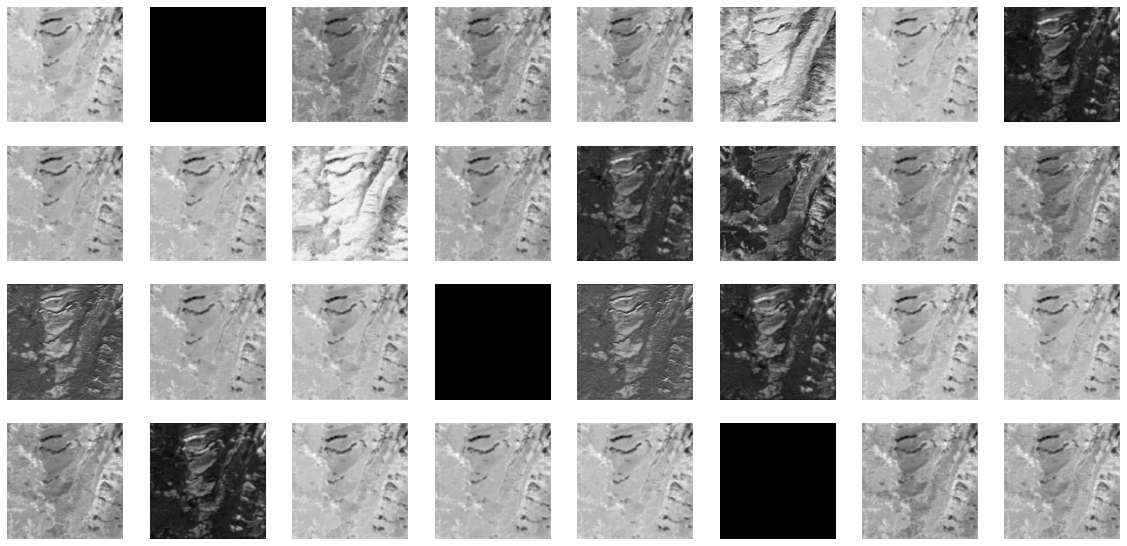

In [212]:
# model.downblocks[1].conv1
rows = 8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(32):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[4][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/4.png')

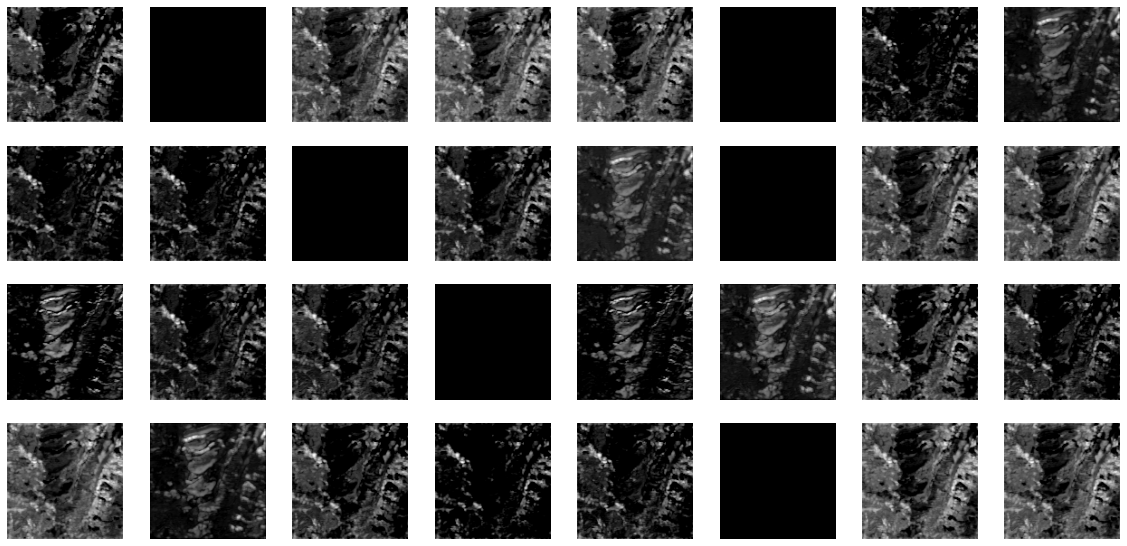

In [211]:
# model.downblocks[1].conv1
rows = 8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(32):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[5][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/5.png')

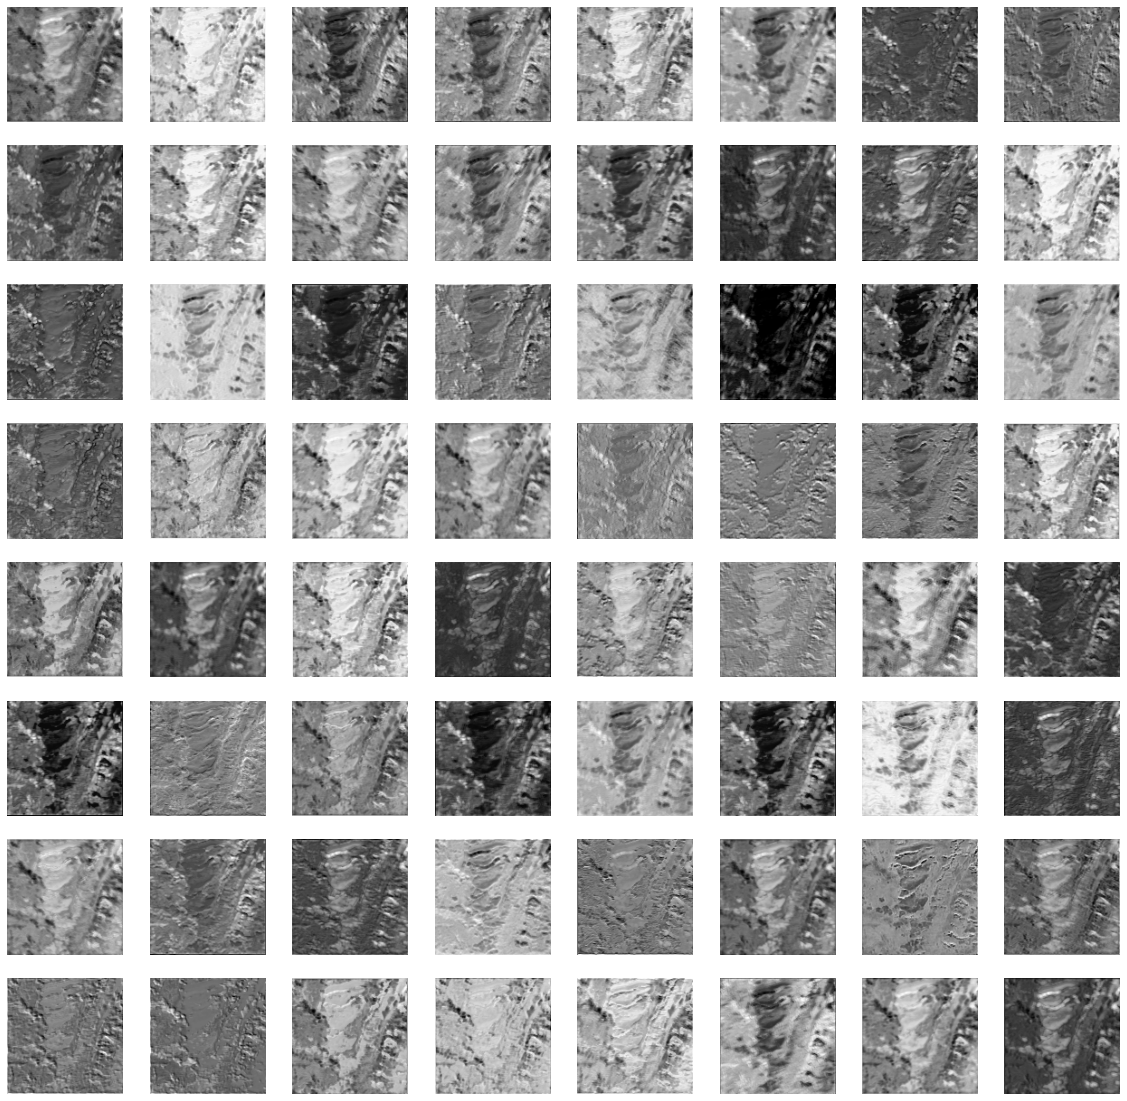

In [216]:
# model.downblocks[1].conv1
rows = 8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(64):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[6][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/6.png')

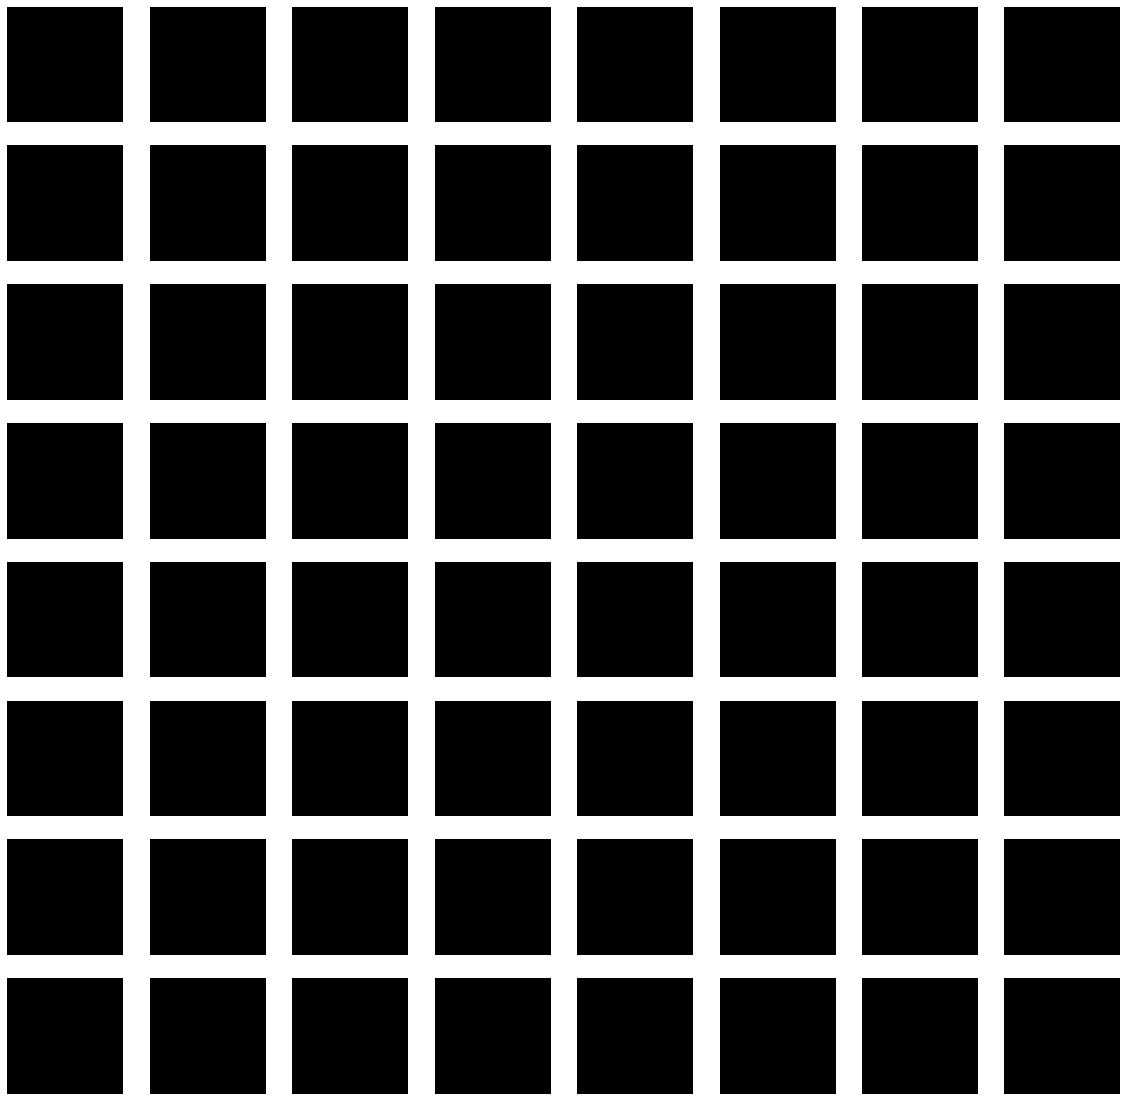

In [217]:
# model.downblocks[1].conv1
rows = 8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(64):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[7][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/7.png')

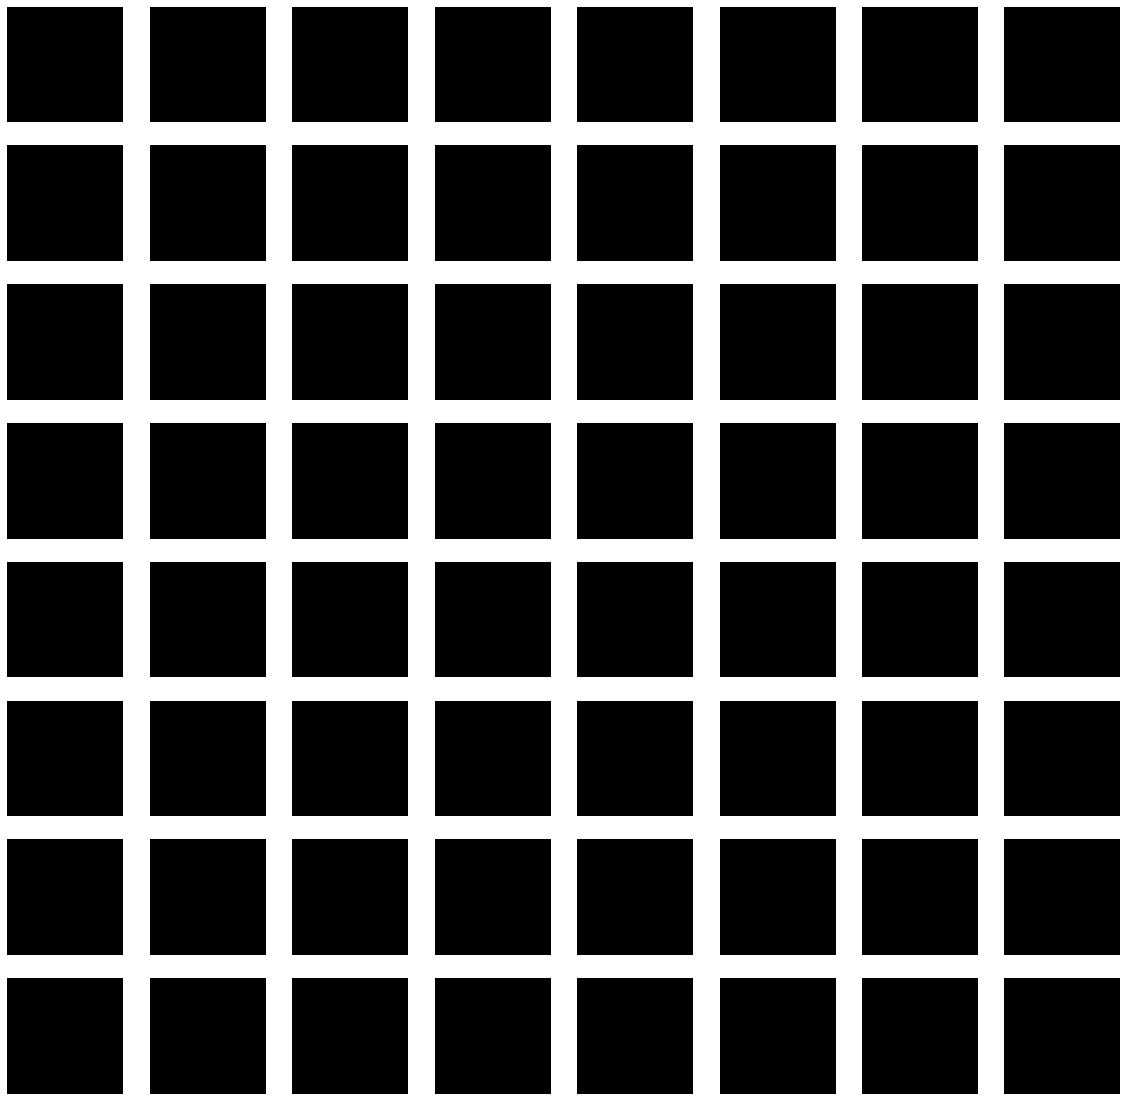

In [218]:
# model.downblocks[1].conv1
rows = 8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(64):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[8][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/8.png')

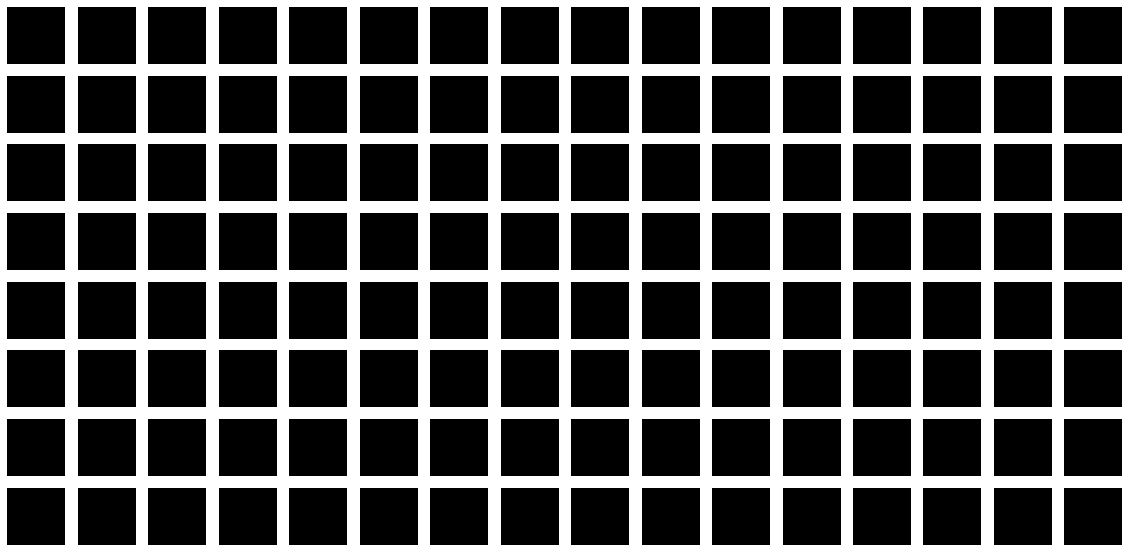

In [219]:
# model.downblocks[1].conv1
rows = 16
columns = 16
fig = plt.figure(figsize=(20, 20))
for i in range(128):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[9][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/9.png')

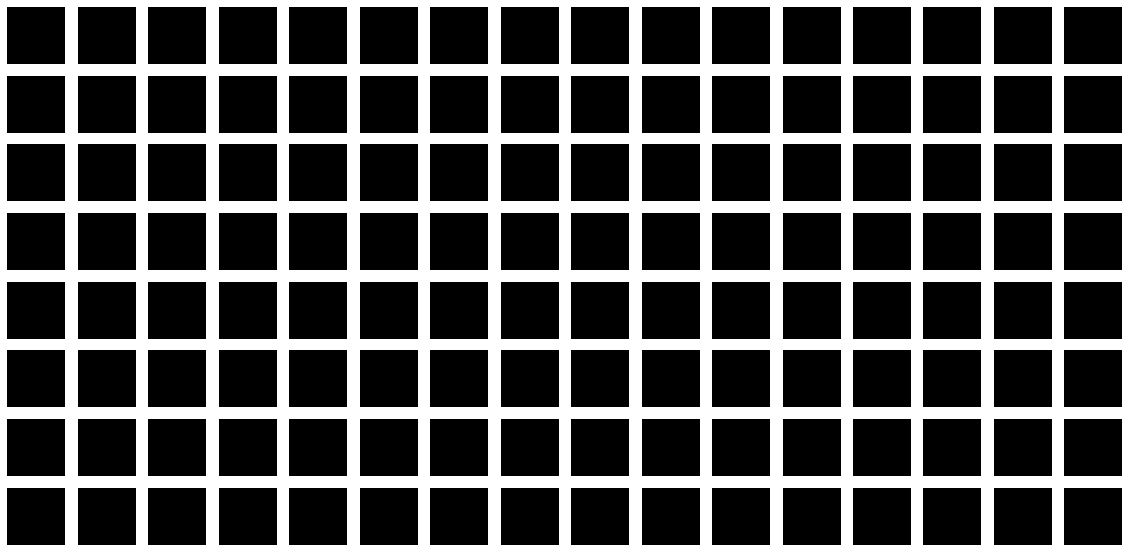

In [220]:
# model.downblocks[1].conv1
rows = 16
columns = 16
fig = plt.figure(figsize=(20, 20))
for i in range(128):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[10][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/10.png')

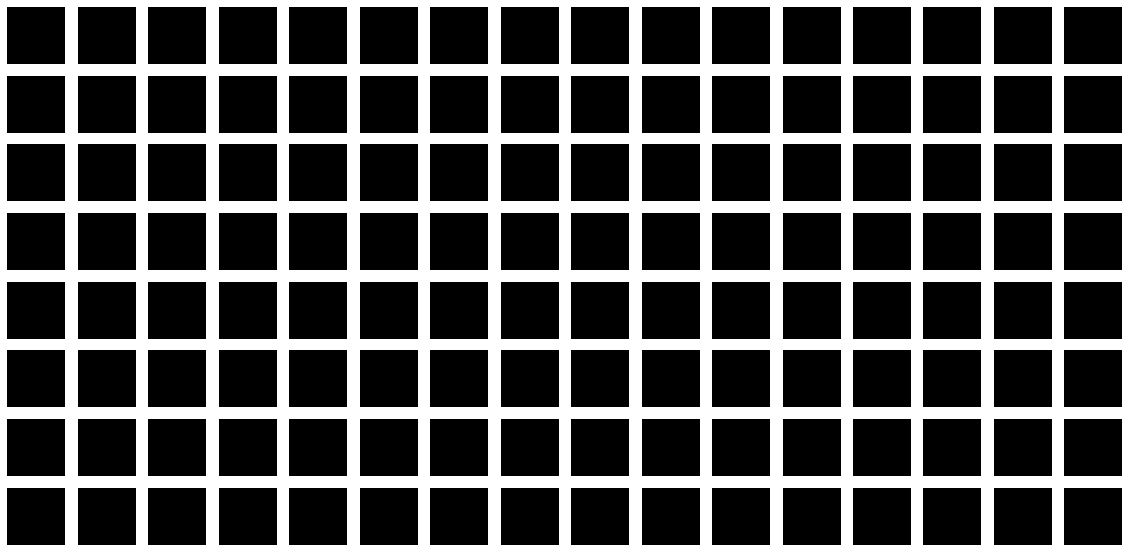

In [221]:
# model.downblocks[1].conv1
rows = 16
columns = 16
fig = plt.figure(figsize=(20, 20))
for i in range(128):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[11][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/11.png')

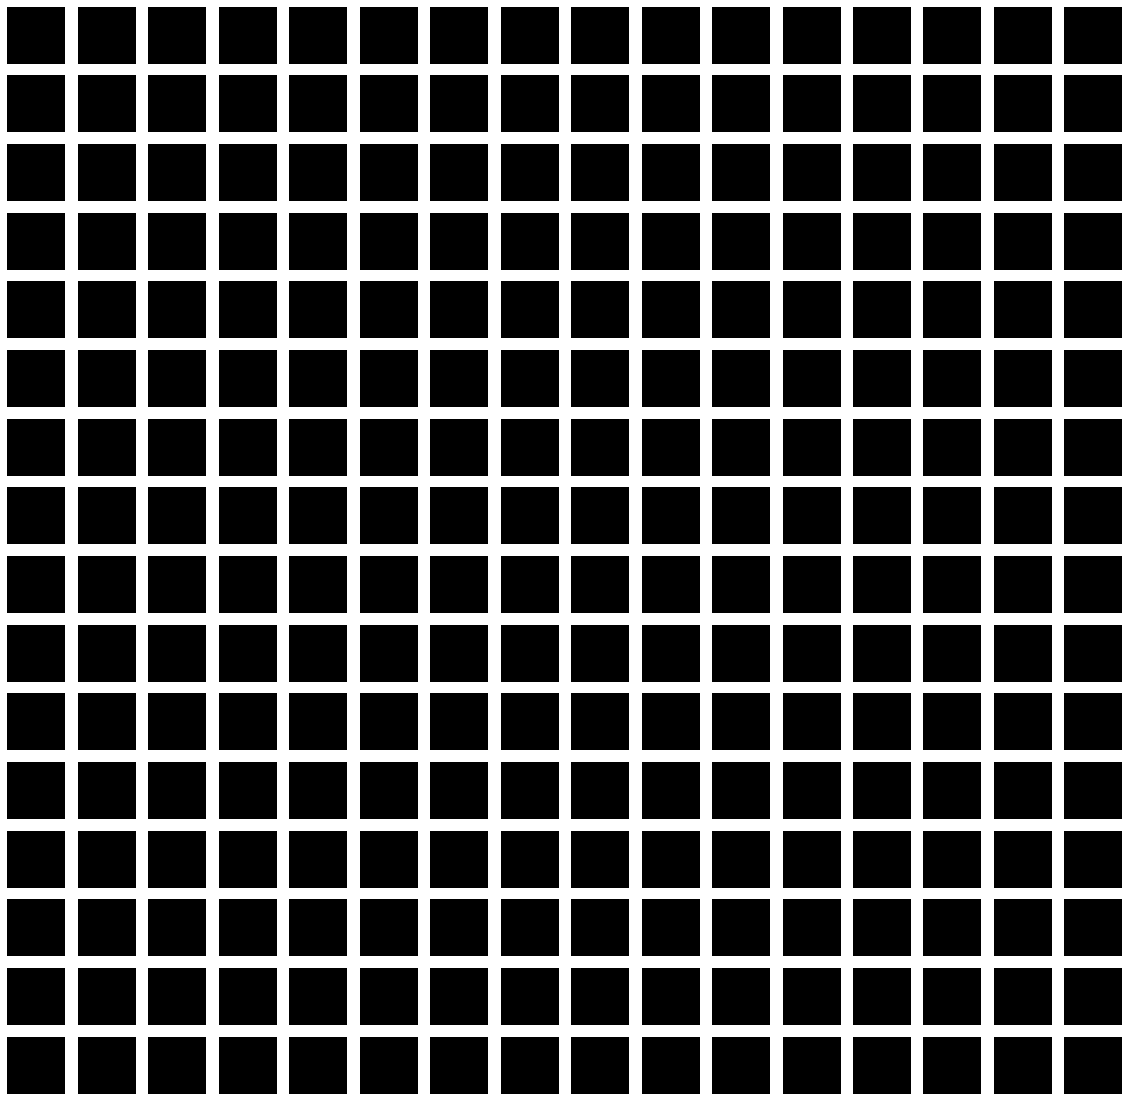

In [222]:
# model.downblocks[1].conv1
rows = 16
columns = 16
fig = plt.figure(figsize=(20, 20))
for i in range(256):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[12][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/12.png')

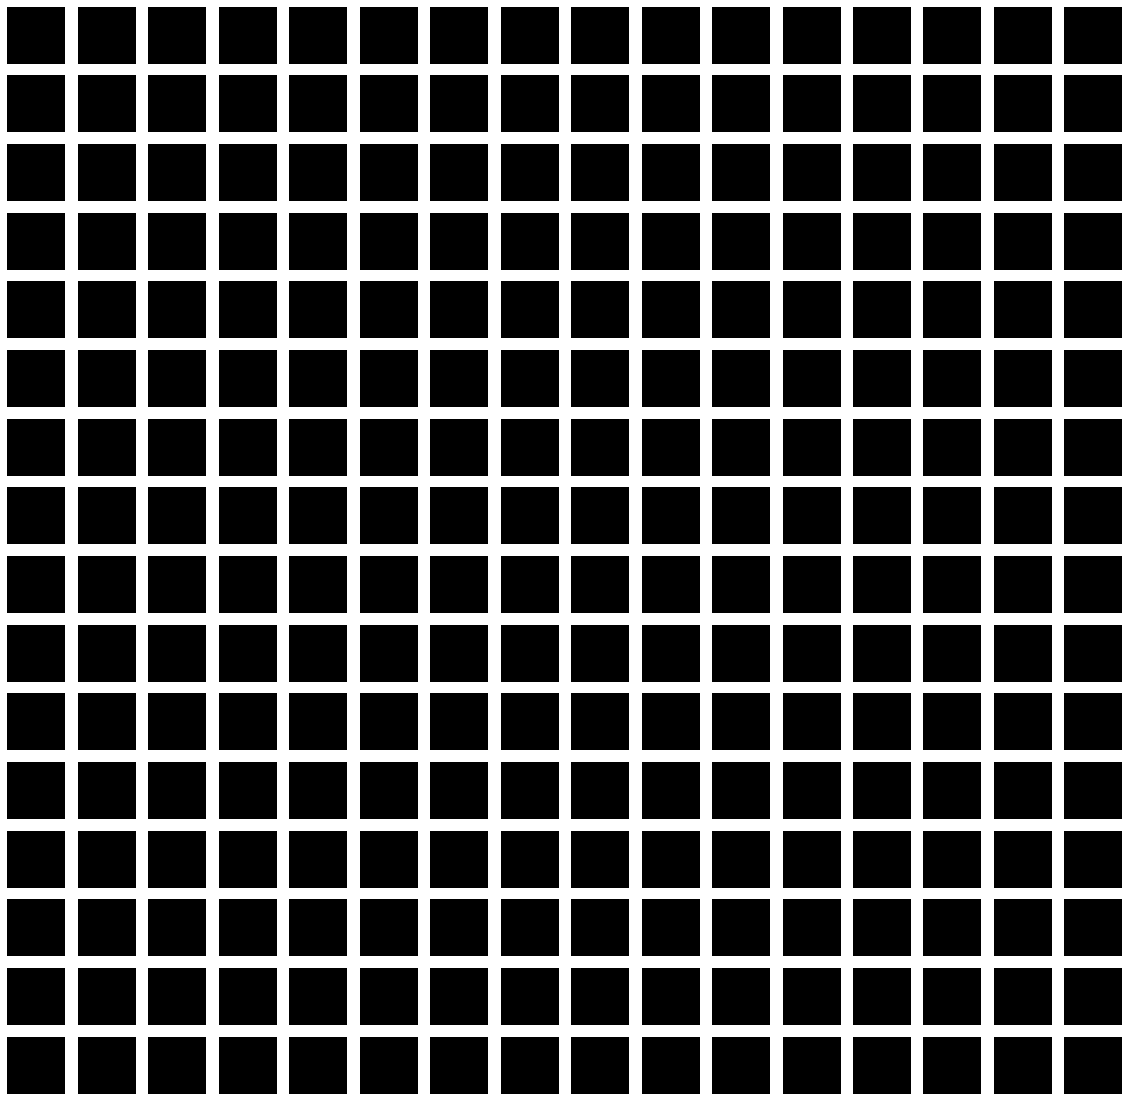

In [223]:
# model.downblocks[1].conv1
rows = 16
columns = 16
fig = plt.figure(figsize=(20, 20))
for i in range(256):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[12][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/13.png')

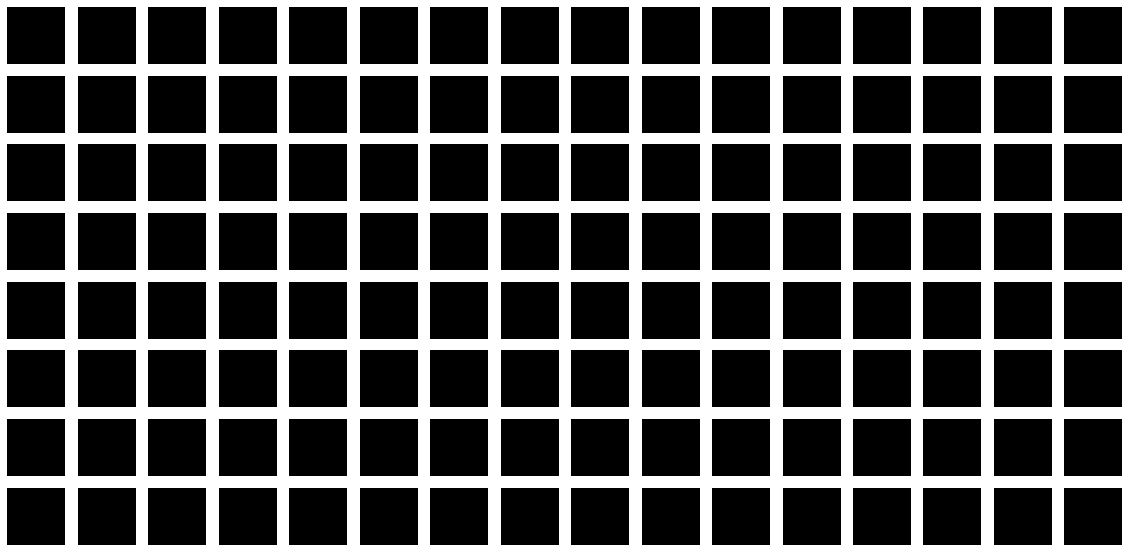

In [224]:
# model.downblocks[1].conv1
rows = 16
columns = 16
fig = plt.figure(figsize=(20, 20))
for i in range(128):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[14][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/14.png')

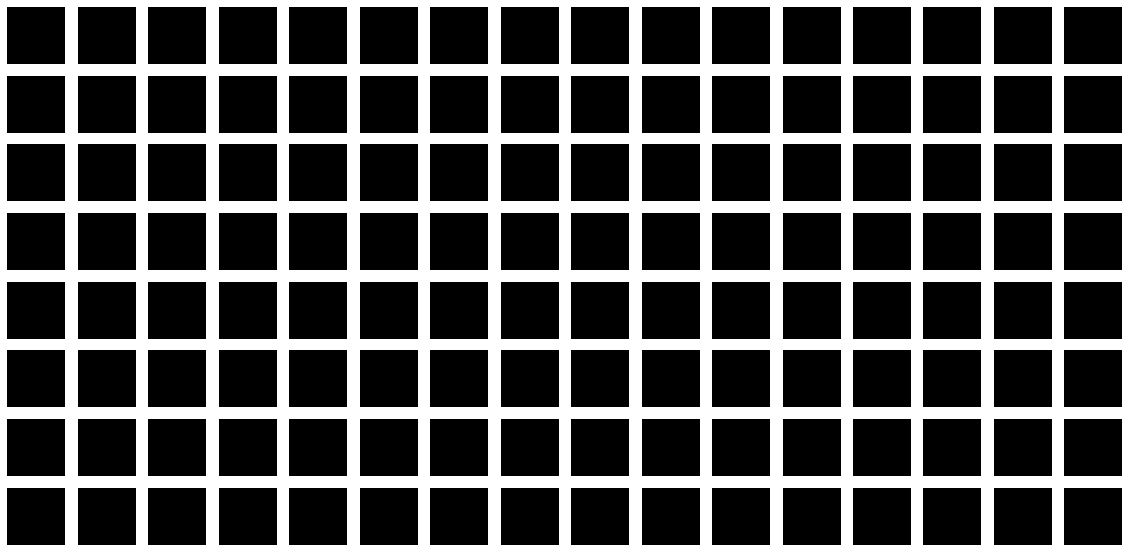

In [225]:
# model.downblocks[1].conv1
rows = 16
columns = 16
fig = plt.figure(figsize=(20, 20))
for i in range(128):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[15][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/15.png')

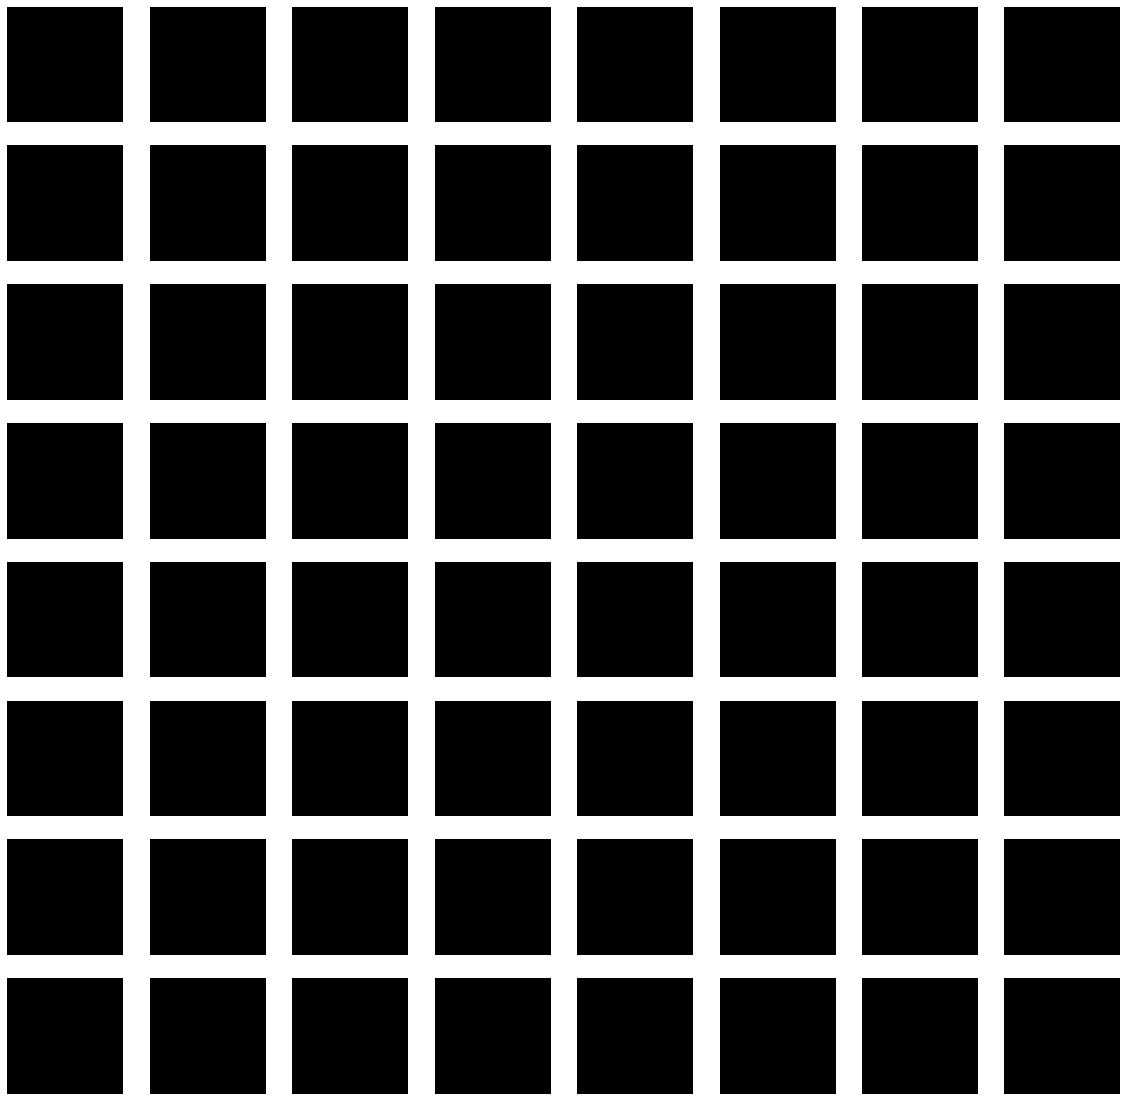

In [226]:
# model.downblocks[1].conv1
rows = 8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(64):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[16][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/16.png')

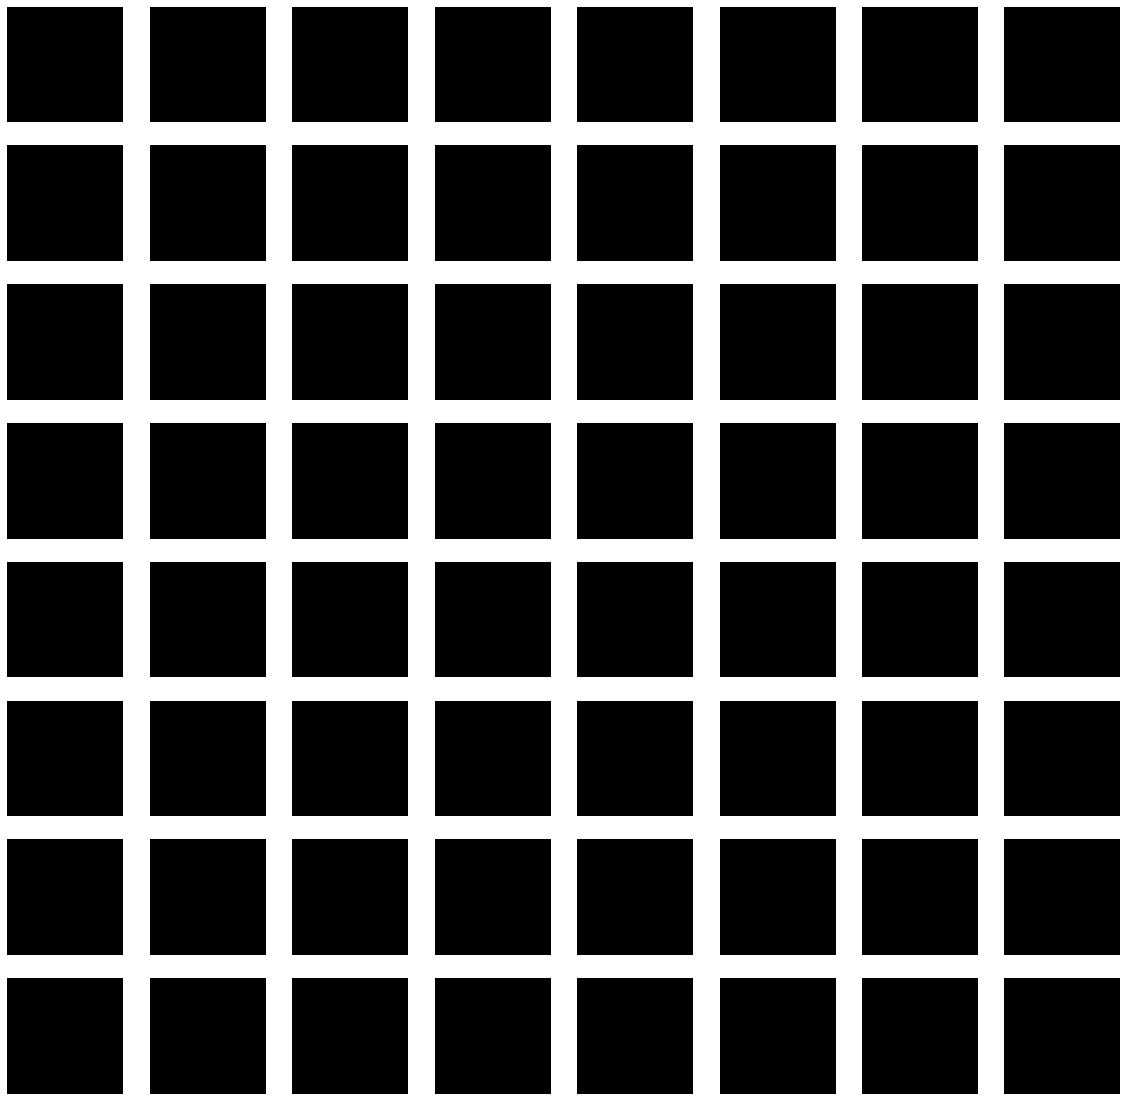

In [227]:
# model.downblocks[1].conv1
rows = 8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(64):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[17][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/17.png')

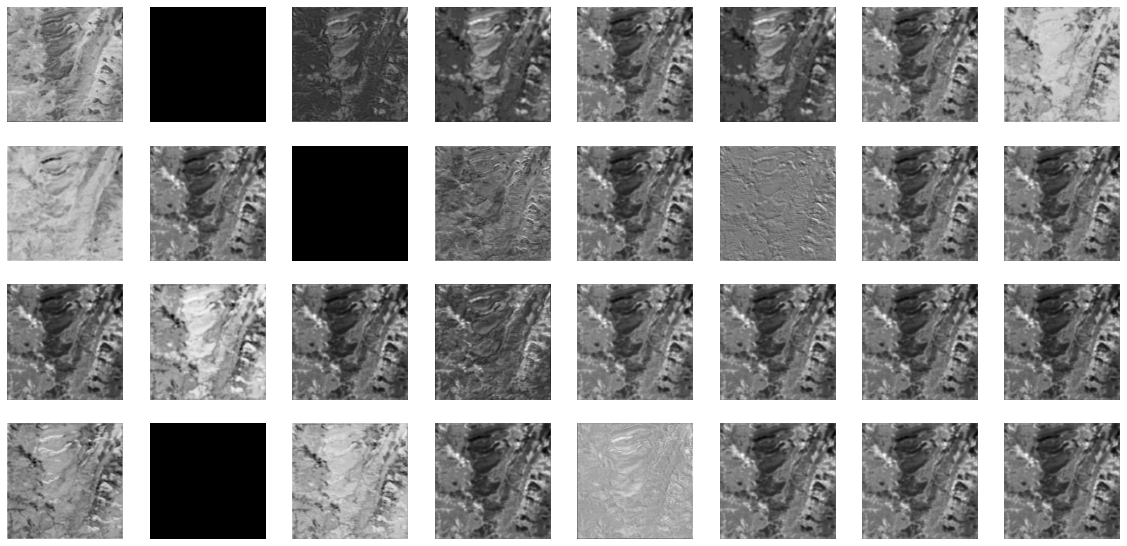

In [228]:
# model.downblocks[1].conv1
rows = 8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(32):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[18][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/18.png')

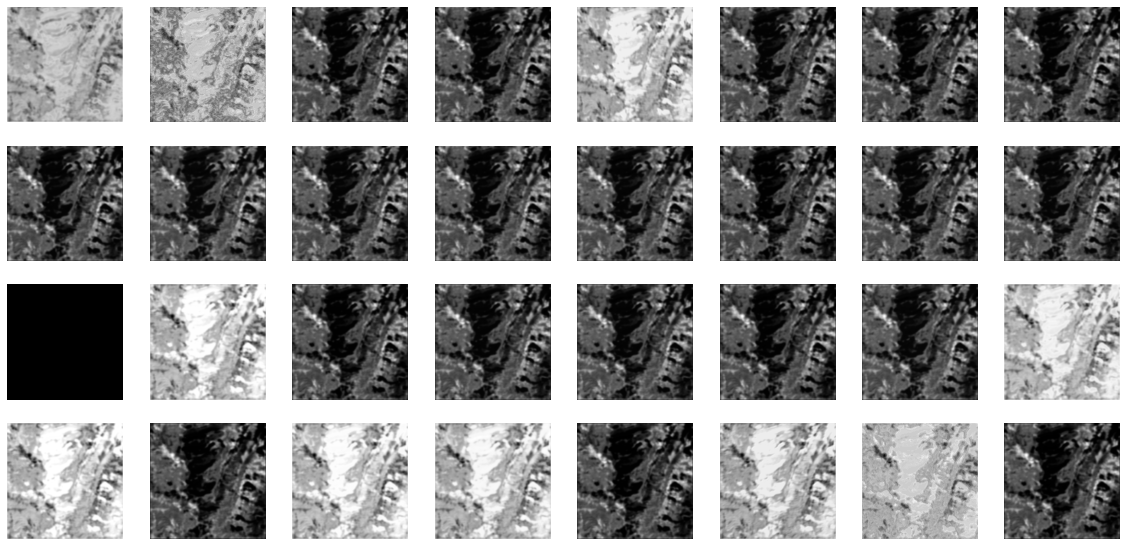

In [229]:
# model.downblocks[1].conv1
rows = 8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(32):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[19][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/19.png')

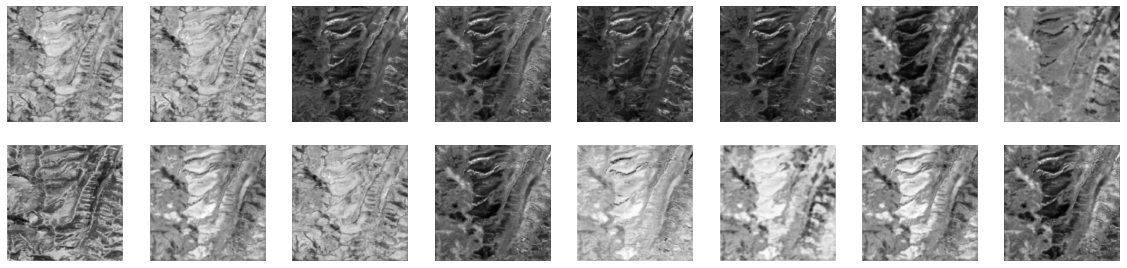

In [232]:
# model.downblocks[1].conv1
rows = 8
columns = 8
fig = plt.figure(figsize=(20, 20))
for i in range(16):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[20][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/20.png')

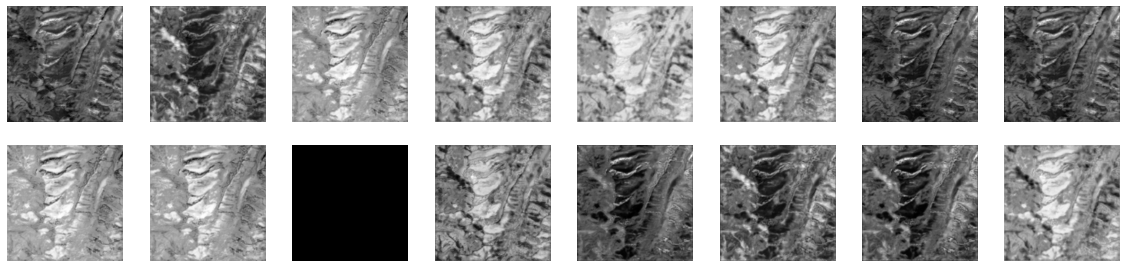

In [231]:
# model.downblocks[1].conv1
rows = 8
columns =8
fig = plt.figure(figsize=(20, 20))
for i in range(16):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[21][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/21.png')

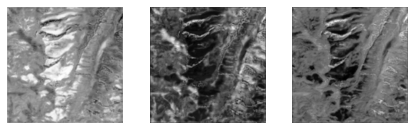

In [236]:
# model.downblocks[1].conv1
rows = 8
columns =8
fig = plt.figure(figsize=(20, 20))
for i in range(3):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(acts[22][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
    plt.axis('off')
plt.savefig(dir+'activations/22.png')

## Combine those activations

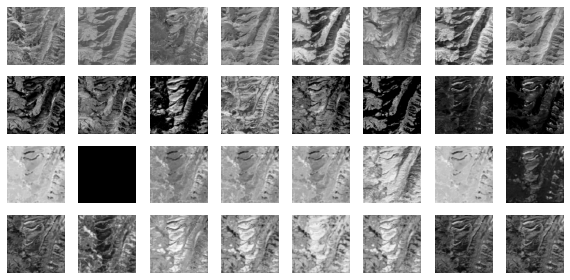

In [259]:
# model.downblocks[1].conv1
rows = 8
columns =8
fig = plt.figure(figsize=(10, 10))
#l = [0,1,2,3,4,5,6,18,19,20,21]
l = [0,2,4,21]
for j in range(4):
    for i in range(8):
        fig.add_subplot(rows, columns, 8 * j+ i + 1)
        plt.imshow(acts[l[j]][0,i,:,:].numpy(), cmap='gray'#, vmin=-1, vmax=1
          )
        plt.axis('off')
plt.savefig(dir+'activations/all.png')

## Plot Y and Yhat

In [129]:
y_hat = model(x.unsqueeze(0))

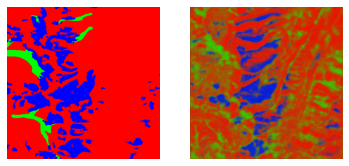

In [198]:
rows = 1;columns = 2
fig = plt.figure(figsize=(6, 10))
fig.add_subplot(rows, columns, 1)
plt.imshow(y.numpy().transpose((1, 2, 0))[:,:,::-1]) # y: (512, 512, 3)
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(y_hat.detach().numpy()[0,:,:,:].transpose((1,2 , 0))[:,:,::-1])
plt.axis('off')
plt.savefig(dir+'y/y.png')

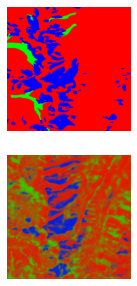

In [255]:
rows = 2;columns = 1
fig = plt.figure(figsize=(5,5))
fig.add_subplot(rows, columns, 1)
plt.imshow(y.numpy().transpose((1, 2, 0))[:,:,::-1]) # y: (512, 512, 3)
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(y_hat.detach().numpy()[0,:,:,:].transpose((1,2 , 0))[:,:,::-1])
plt.axis('off')
plt.savefig(dir+'y/yv.png')